<a href="https://colab.research.google.com/github/shk0349/AI_Study_24/blob/master/LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM과 GRU 셀
- 순환신경망에서 빼놓을 수 없는 핵심 기술
- SimpleRNN 보다 훨씬 복잡하지만 성능이 뛰어나기 때문에 순환 신경망에 많이 채택됨 (일반적으로 기본 순환층은 긴 시퀀스를 학습하기 힘듦)
- 시퀀스가 길수록 순환되는 은닉 상태에 담긴 정보가 점차 희석됨
- 멀리 떨어져 있는 단어 정보를 인식하는데 어려울 수 있음 -> LSTM, GRU 사용함
- LSTM(Long Short-Term Memory)는 말그대로 단기 기억을 오래 기억하기 위해 고안된것으로 기본 개념은 동일함 (입력과 가중치를 곱하고 절편을 더하여 활성함수를 통과시키는 구조를 여러개 갖고 있으며, 이런 계산 결과는 다음 타임스텝이 재사용됨)

1. 은닉상태를 만듦 : 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한후 활성화 함수를 통과시켜 다음 은닉 상태를 만듦 / 이때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용하며 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만듦

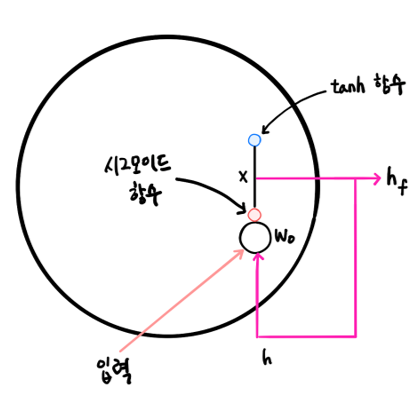

위 그림은 가중치 x_y와 w_h를 통틀어 w_o라고 표시한것이며, 파란색 원은 tanh 함수, 주황색 원은 시그모이드 함수임 (x는 곱셈을 나타내며, 기본 순환층과 크게 다르지 않음)

tanh 함수를 통과하는 값은 무엇인지 확인해보면, LSTM에는 순환되는 상태는 2개(은닉상태, 셀상태)이고, 셀 상태는 은닉상태와 달리 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값임

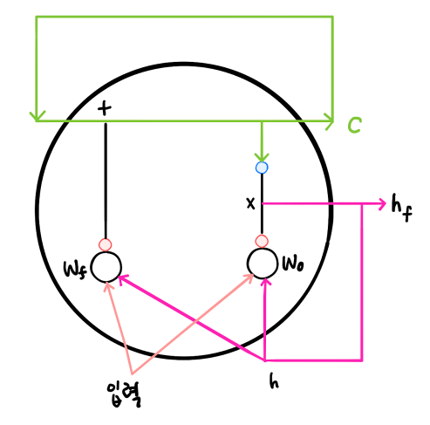

위 그림의 녹색은 순환되는 셀의 상태를 나타내며, 셀 상태를 은닉상태 h와 구분하여 c로 표시함

셀 상태를 계산하는 과정
- 먼저 입력과 은닉 상태를 가중치 w_f에 곱한 후 시그모이드 함수를 통과함
- 이전 타임스텝의 셀 상태와 곱하여 새로운 셀의 상태를 만듦 (이 셀 상태가 오른쪽에서 tanh 함수를 통과하여 새로운 은닉 상태를 만드는데 기여하며, LSTM은 마치 작은 셀을 여러개 포함하고 있는 큰 셀 같음)
- 중요한 것은 입력과 은닉 상태에서 곱해지는 가중치 w_o와 w_f가 다르며, 이 두 작은 셀은 각기 다른 기능을 위해 훈련됨
- 여기에 2개의 작은 셀이 더 추가되어 셀의 상태를 만드는데 기여

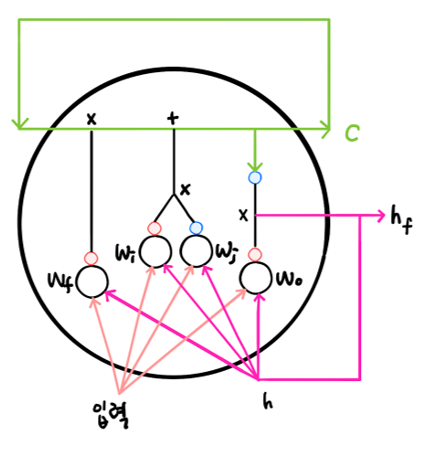

위 그림은 이전과 마찬가지로 입력과 은닉 상태를 각기 다른 가중치에 곱한 후 하나는 시그모이드 함수를 통과, 다른 하나는 tanh 함수를 통과시켜 그 두 결과를 곱한 후 이전 셀의 상태와 더함(최종 상태의 셀)

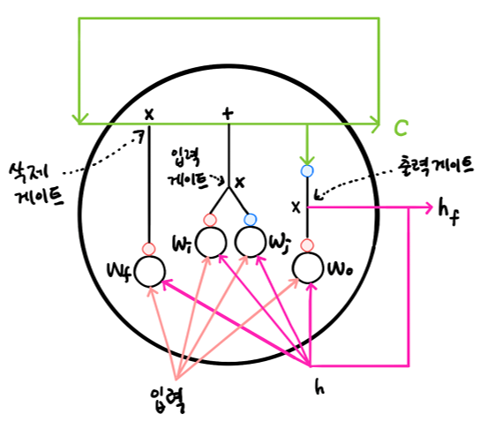

세곳의 곱셈을 각각 삭제 게이트, 입력 게이트, 출력 게이트라고 부름
- 삭제 게이트 : 셀의 상태에 있는 정보를 제거하는 역할
- 입력 게이트 : 새로운 정보를 셀 상태에 추가
- 출력 게이트 : 셀 상태가 다음 은닉 상태로 출력

위 처리는 keras의 LSTM 클래스가 알아서 돌림

In [2]:
# LSTM 신경망 훈련

import tensorflow as tf
tf.keras.utils.set_random_seed(42)

from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words = 500)

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print(train_input.shape, test_input.shape, val_input.shape)

(20000,) (25000,) (5000,)


In [4]:
# keras의 pad_sequences() 함수로 각 샘플의 길이를 100에 맞추고 부족할 때 패딩 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen = 100)    # truncation = 'pre' : 생략가능
val_seq = pad_sequences(val_input, maxlen = 100)

In [5]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [7]:
# LSTM 셀을 사용한 순환층 생성(SimpleRNN 클래스 대신 LSTM으로 변경만 하면 됨)
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_shape = (100, )))    # 벡터를 이용한 토큰 처리
# 어휘사전크기 : num_words = 500 / 임베딩 벡터크기 : 16 / maxlen = 100
model.add(keras.layers.LSTM(8))    # 뉴런개수 : 8
model.add(keras.layers.Dense(1, activation = 'sigmoid'))    # 활성화 함수 : Sigmoid(2진분류)

model.summary()
# SimpleRNN 클래스의 모델 파라미터 개수는 200개 -> LSTM 셀에는 작은 셀이 4개가 있으므로 정확히 800임

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# compile 및 훈련시작
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

# 배치 크기는 64, 에포크 회수는 100으로 지정 / 체크포인트 및 조기종료 적용
history = model.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.5150 - loss: 0.6930 - val_accuracy: 0.5414 - val_loss: 0.6924
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.5656 - loss: 0.6918 - val_accuracy: 0.5738 - val_loss: 0.6909
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.5927 - loss: 0.6900 - val_accuracy: 0.5928 - val_loss: 0.6884
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6110 - loss: 0.6868 - val_accuracy: 0.6054 - val_loss: 0.6837
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6225 - loss: 0.6809 - val_accuracy: 0.6262 - val_loss: 0.6750
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6409 - loss: 0.6701 - val_accuracy: 0.6500 - val_loss: 0.6583
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6631 - loss: 0.6489 - val_accuracy: 0.6836 - val_loss: 0.6232
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7008 - loss: 0

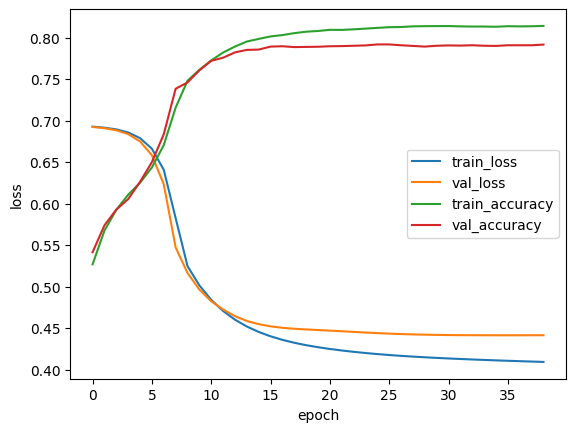

In [9]:
# 39회 에포크 / 81.44% 정확도

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])
plt.show()

결과를 확인하면 기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행하는 것처럼 보이나, 경우에 따라서 과대적합을 더 강하게 제어할 필요성이 있음 -> Dropout 사용 필요

완전 연결 신경망과 합성곱 신경망에서는 Dropout 클래스를 사용하여 드롭아웃을 적극 적용하여 모델이 훈련세트에 너무 과대적합되는 것을 억제하였음

순환층은 자체적으로 드롭아웃 기능을 제공흠 -> 드롭아웃(은닉층에 있는 뉴런의 출력을 랜덤하게 off 시켜 과대적합을 억제)

SimpleRNN과 LSTM 클래스 모두 Dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있음

dropout은 셀의 입력에 드롭아웃을 적용하며, recurrent_dropout은 순환은닉 상태에 드롭아웃을 적용함

recurrent_dropout을 사용하면 GPU를 사용하여 모델을 훈련하지 못하여(모델의 훈련 속도가 크게 감소) 이번에는 dropout만 적용할 예정


In [12]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16, input_shape = (100, )))
model2.add(keras.layers.LSTM(8, dropout = 0.3))    # 드롭아웃 매개값 0.3으로 지정(30% 드롭아웃)
model2.add(keras.layers.Dense(1, activation = 'sigmoid'))
model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model2.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5180 - loss: 0.6927 - val_accuracy: 0.5476 - val_loss: 0.6915
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.5853 - loss: 0.6901 - val_accuracy: 0.6132 - val_loss: 0.6876
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - accuracy: 0.6221 - loss: 0.6849 - val_accuracy: 0.6416 - val_loss: 0.6778
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6565 - loss: 0.6715 - val_accuracy: 0.6938 - val_loss: 0.6395
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.7019 - loss: 0.6136 - val_accuracy: 0.7190 - val_loss: 0.5589
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.7238 - loss: 0.5537 - val_accuracy: 0.7460 - val_loss: 0.5298
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.7494 - loss: 0.5238 - val_accuracy: 0.7608 - val_loss: 0.5088
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.7615 - loss: 0

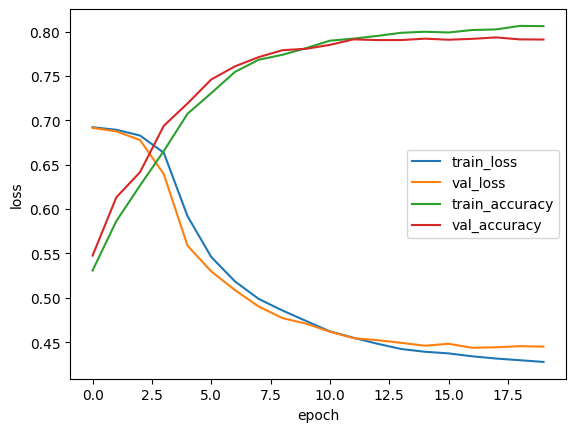

In [14]:
# 20회 에포크 / 80.57% 정확도

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])
plt.show()    # 훈련손실과 검증손실 간 차이가 좁혀짐

# 2개의 층 연결
- 순환층을 연결할 때는 한가지 주의할 사항이 있음
- 순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음층으로 전달되나, 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요함
- 앞쪽의 순환층이 모든 타임스텝에 대한 은닉상태를 출력해야하며, 오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야함

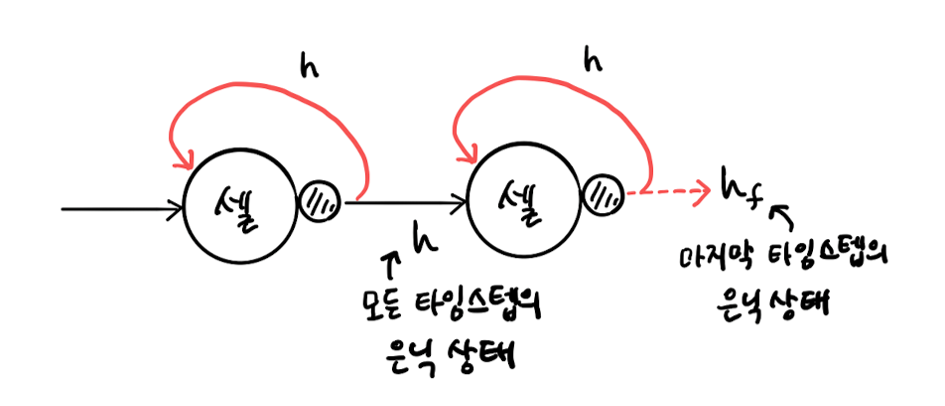

In [15]:
# keras의 순환층에서 모든 타임스텝의 은닉상태를 출력하려면,
# 마지막을 제외한 다른 모든 순환층에서 return_sequences = True로 지정함
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_shape = (100, )))
model3.add(keras.layers.LSTM(8, dropout = 0.3, return_sequences = True))    # 1번 LSTM
model3.add(keras.layers.LSTM(8, dropout = 0.3))    # 2번 LSTM
model3.add(keras.layers.Dense(1, activation = 'sigmoid'))

model3.summary()
# 첫번째 LSTM 층이 모든 타임스텝(100개)의 은닉상태를 출력하기 때문에 출력 크기가(None, 100, 8)로 표시됨
# 이에반해 두번째 LSTM 층의 출력크기는 마지막 타임스텝의 은닉상태만 출력하기 때문에 (None, 8)로 표시됨

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100, 8)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# 훈련시작
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model3.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model3.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.5080 - loss: 0.6930 - val_accuracy: 0.5132 - val_loss: 0.6927
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.5373 - loss: 0.6922 - val_accuracy: 0.6018 - val_loss: 0.6912
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.5917 - loss: 0.6901 - val_accuracy: 0.6424 - val_loss: 0.6856
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.6227 - loss: 0.6809 - val_accuracy: 0.6770 - val_loss: 0.6521
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.6745 - loss: 0.6332 - val_accuracy: 0.7066 - val_loss: 0.5725
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.7083 - loss: 0.5731 - val_accuracy: 0.7306 - val_loss: 0.5394
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.7354 - loss: 0.5413 - val_accuracy: 0.7468 - val_loss: 0.5200
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.7544 - loss: 

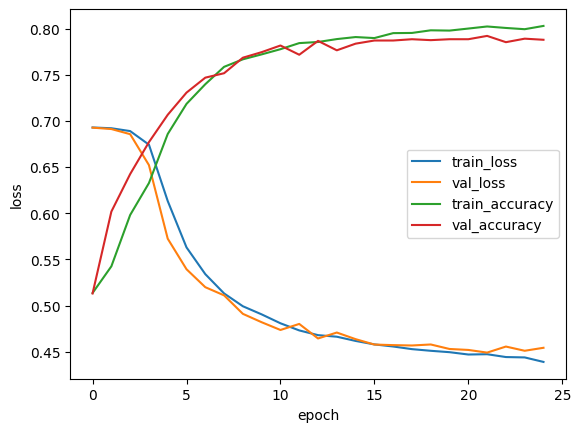

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])
plt.show()    # 과대적합을 억제하면서 손실을 최대한 낮춘듯함

# GRU(Gated Recurrent Units) 구조
- 뉴욕대학교 조경현 교수가 발명한 셀로 유명하며(LSTM을 간소화 버전으로 만듦),셀 상태로 계산하지 않고 은닉상태 하나만 포함함

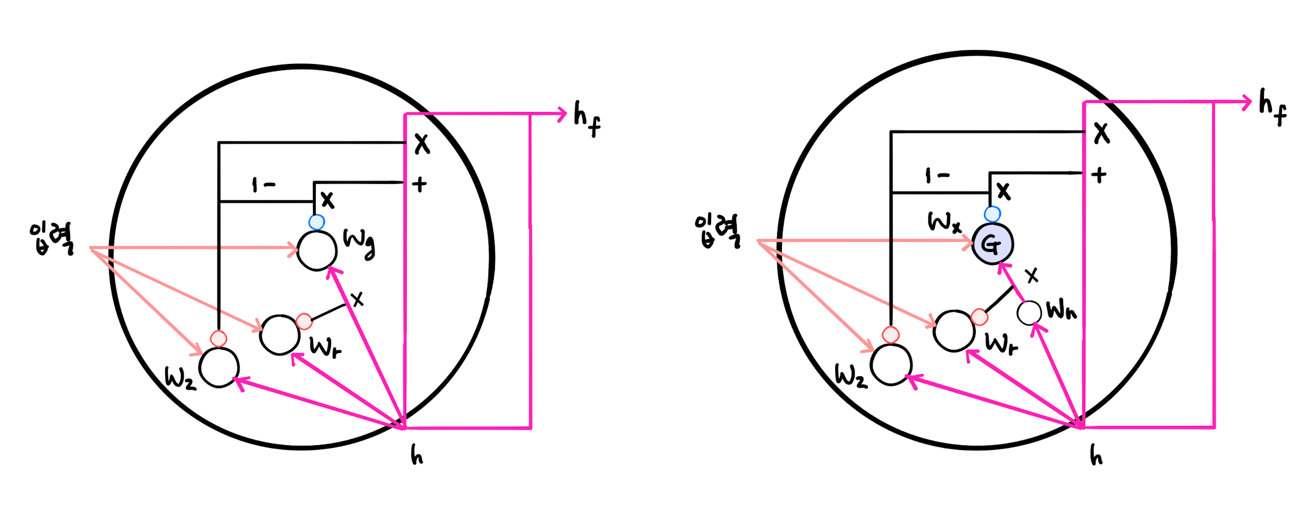

GRU셀에는 은닉상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있고, 2개는 시그모이드 활성화함수를 사용하고 하나는 tanh 활성화함수를 사용함 (여기에도 은닉상태와 곱해지는 가중치를 합쳐서 나타냄)

맨 왼쪽 w_z를 사용하는 셀의 출력이 은닉상태에서 바로 곱해져 삭제 게이트 역할을 수행하고, 이와 똑같은 출력은 1에서 뺀 다음에 가장 오른쪽 w_g를 사용하는 셀의 출력에 곱함 (이는 입력되는 정보를 제어하는 역할을 수행함)

가운데 w_r을 사용하는 셀에서는 출력된 w_g 셀이 사용할 은닉 상태의 정보를 제어함

GRU 셀은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지 않게 좋은 성능을 냄

In [20]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_shape = (100, )))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation = 'sigmoid'))

model4.summary()
# 파라미터를 계산해보면 GRU 셀에는 3개의 작은 셀이 있고,
# 작은 셀에는 입력과 은닉상태에 곱하는 가중치와 절편이 있음
# 입력에 곱하는 가중치는 128개(16 x 8)이고, 은닉 상태에 곱하는 가중치는 64(8 x 8)이고. 절편은 뉴런마다 하나씩이므로 8개임
# 모두 더하면 200(128 + 64 + 8)이고 이런 작은 셀이 3개이므로 600개(200 x 3)dla

# 624개가 된 이유는 3개의 절편마다 8개의 뉴런까지 존재하므로 24(3 x 8)까지 더해짐(624 = 600 + 24)
# tensorflow가 이런 계산 방식을 사용하는 이유는 GPU를 잘 활용하기 위함임(LSTM 개선점)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 100, 16)             │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 8)                   │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# GRU 신경망 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model4.compile(optimizer = rmsprop, loss = 'binary_crossentropy', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras', save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)
history = model4.fit(train_seq, train_target, epochs = 100, batch_size = 64, validation_data = (val_seq, val_target), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5244 - loss: 0.6926 - val_accuracy: 0.5472 - val_loss: 0.6915
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5615 - loss: 0.6905 - val_accuracy: 0.5740 - val_loss: 0.6890
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5884 - loss: 0.6874 - val_accuracy: 0.5912 - val_loss: 0.6849
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6068 - loss: 0.6824 - val_accuracy: 0.6028 - val_loss: 0.6782
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.6227 - loss: 0.6742 - val_accuracy: 0.6190 - val_loss: 0.6676
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.6353 - loss: 0.6613 - val_accuracy: 0.6378 - val_loss: 0.6509
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.6536 - loss: 0.6410 - val_accuracy: 0.6706 - val_loss: 0.6238
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.6830 - loss: 0

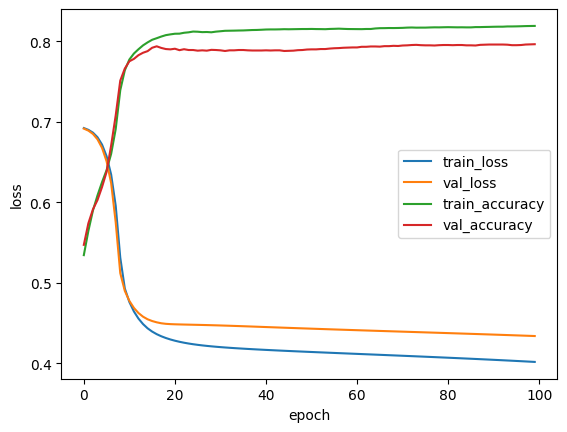

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])
plt.show()

In [23]:
test_seq = pad_sequences(test_input, maxlen = 100)

gru_model = keras.models.load_model('best-gru-model.keras')

gru_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8015 - loss: 0.4308


[0.43033120036125183, 0.8009600043296814]